In [11]:
import string
import random
from random import randint
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
from scipy import ndimage 
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

### Setup: set file paths

In [28]:
MODEL_SAVE_PATH = '/home/fizzer/ros_ws/src/controller_pkg/assets/models/character_recognition_compressed'
MODEL_LOAD_PATH = '/home/fizzer/ros_ws/src/controller_pkg/assets/models/character_recognition'
LOAD_MODEL = True

# Part 1: Test generating single letter

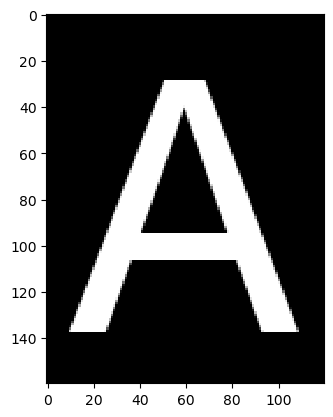

In [13]:
zeros = np.zeros(shape=(160,120), dtype=np.uint8)
# plt.imshow(zeros)
image = Image.fromarray(zeros)
draw = ImageDraw.Draw(image)
font = ImageFont.truetype(r"/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 165)
text = "A"
draw.text(xy=(10,0), text=text, font=font, fill=255)

letter_image = np.array(image)
plt.imshow(letter_image, cmap='gray')

## 1.2 Dict from Character -> Index

In [14]:
chars = list(string.ascii_uppercase + string.digits)
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for i,c in enumerate(chars)}
print(ctoi)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


# Part 2: Generate list of image of each character

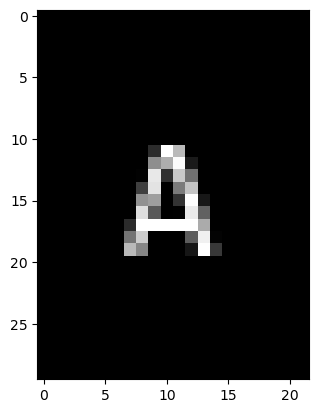

In [15]:
letter_images = []

FONT_HEIGHT = 15


for i in range(36):
    zeros = np.zeros(shape=(int(FONT_HEIGHT * 2), int(FONT_HEIGHT * 1.5)), dtype=np.uint8)
    # plt.imshow(zeros)
    image = Image.fromarray(zeros)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(r"/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf", FONT_HEIGHT)
    text = itoc[i]
    # print(font.getsize(text))
    draw.text(xy=(FONT_HEIGHT*0.5,FONT_HEIGHT*0.5), text=text, font=font, fill=255)
    letter_image = np.array(image)
    letter_images.append(letter_image)

letter_images = np.stack([ im for im in letter_images], axis=0)
letter_images.shape

# show random one
plt.imshow(letter_images[np.random.randint(36)], cmap='gray')

## 2.2: Rotate images

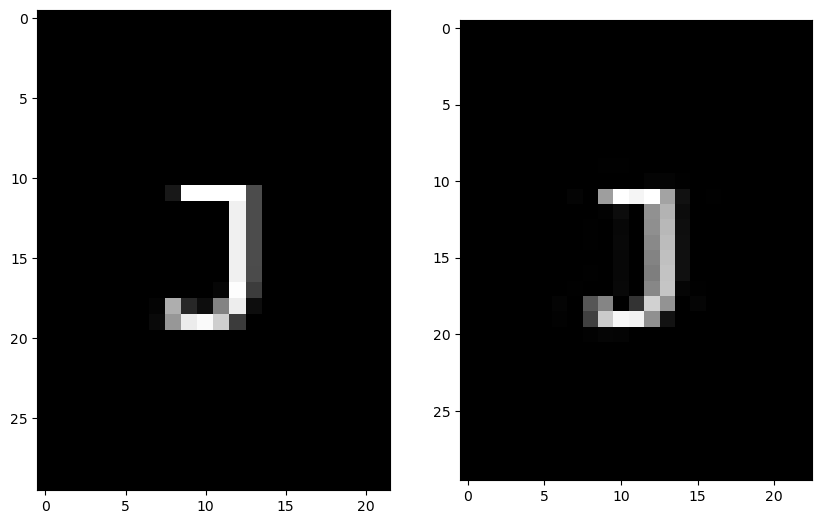

In [16]:
image = letter_images[np.random.randint(0,36)]
rotated = ndimage.interpolation.rotate(image, np.random.randint(-20,20), axes=(0,1), reshape=True)
# show random one 
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(rotated, cmap='gray')

## 2.4 Perspective Transform

In [17]:
def unit_rand():
    return np.random.rand() * 2 - 1

[[ 9.16287983e-01 -3.83950603e-02  7.76176691e-01]
 [-8.92457657e-02  9.52758344e-01  6.86718524e-01]
 [-5.67777393e-03 -6.85399146e-04  1.00000000e+00]]


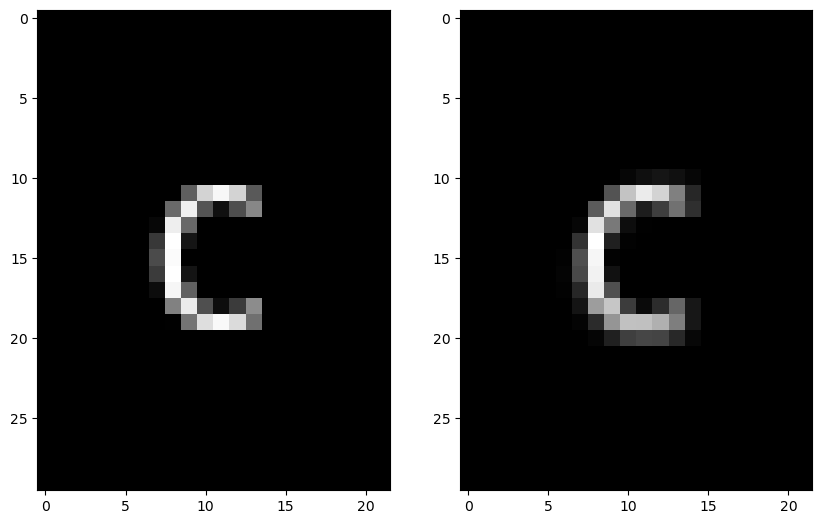

In [18]:
# Locate points of the documents
    # or object which you want to transform
image = letter_images[np.random.randint(0,36)]

RAND_RANGE = 0.8

pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)
print(matrix)
result = cv2.warpPerspective(image, matrix, image.T.shape, flags=cv2.INTER_LINEAR)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(result, cmap='gray')

## 2.5 Random compression and extrapolation

#### Shrink down the size of the image to something like 10x8 pixels, then resize to original, creating random data losses

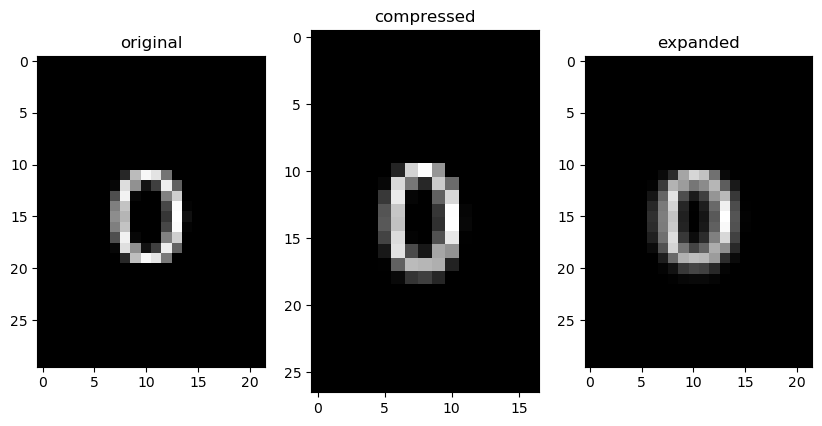

In [19]:
image = letter_images[np.random.randint(0,36)]
x_ratio = np.random.rand() * 0.3 + 0.7 # 0.3 ~ 1
y_ratio = np.random.rand() * 0.3 + 0.7 # 0.3 ~ 1
compressed = cv2.resize(image, (0,0), fx=x_ratio, fy=y_ratio)
expanded = cv2.resize(compressed, (image.shape[1], image.shape[0]))
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
titles = ['original', 'compressed', 'expanded']
for i, ax in enumerate(axs):
    ax.imshow([image, compressed, expanded][i], cmap='gray')
    ax.set_title(titles[i])

## 2.5: All together

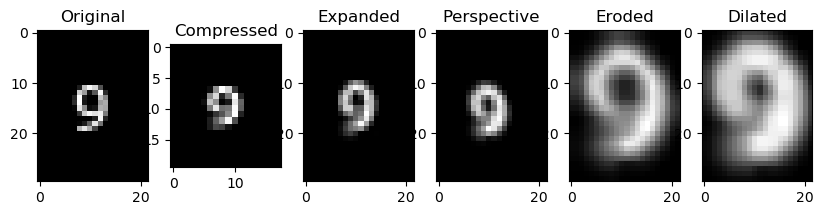

In [20]:

image = letter_images[np.random.randint(0,36)]
x_ratio = np.random.rand() * 0.4 + 0.6 # 0.6 ~ 1
y_ratio = np.random.rand() * 0.4 + 0.6 # 0.6 ~ 1
compressed = cv2.resize(image, (int(image.shape[1]*x_ratio), int(image.shape[0]*y_ratio)))
expanded = cv2.resize(compressed, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)
warped = cv2.warpPerspective(expanded, matrix, image.T.shape, flags=cv2.INTER_LINEAR)
contours, hierarchy = cv2.findContours(warped, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
x,y,w,h = cv2.boundingRect(max(contours, key = cv2.contourArea))
cropped = cv2.resize(warped[y:y+h, x:x+w], warped.T.shape)
eroded = cv2.erode(cropped, np.ones((2,2), np.uint8), iterations=1)
dilated = cv2.dilate(cropped, np.ones((2,2), np.uint8), iterations=1)


fig, axs = plt.subplots(1, 6, figsize=(10, 10))
titles = ['Original', 'Compressed', 'Expanded', 'Perspective', 'Eroded', 'Dilated']
for i, ax in enumerate(axs):
    ax.set_title(titles[i])
axs[0].imshow(image, cmap='gray')
axs[1].imshow(compressed, cmap='gray')
axs[2].imshow(expanded, cmap='gray')
axs[3].imshow(warped, cmap='gray')
axs[4].imshow(eroded, cmap='gray')
axs[5].imshow(dilated, cmap='gray')


# Part 3: Batch-ify it

In [21]:
RAND_RANGE = 0.6

X = letter_images.copy()
Y = tf.one_hot(np.arange(36), depth=36)

for i in range(2000):
    # shifted = shift_image_batch(letter_images, SHIFT_RANGE, SHIFT_RANGE)
    rotated = ndimage.interpolation.rotate(letter_images, np.random.randint(-20,20), axes=(1,2), reshape=False)
    results = []
    for j in range(36):
        # x_ratio = np.random.rand() * 0.4 + 0.6 # 0.6 ~ 1
        # y_ratio = np.random.rand() * 0.4 + 0.6 # 0.6 ~ 1
        # compressed = cv2.resize(rotated[j], (int(rotated[j].shape[1]*x_ratio), int(rotated[j].shape[0]*y_ratio)))
        # expanded = cv2.resize(compressed, (rotated[j].shape[1], rotated[j].shape[0]), interpolation=cv2.INTER_CUBIC)
        pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
        pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
        # Apply Perspective Transform Algorithm
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        result = cv2.warpPerspective(rotated[j], matrix, rotated[j].T.shape, flags=cv2.INTER_LINEAR)
        # erode or dilate
        erosion_dilation_factor = np.random.randint(1,3)
        if np.random.rand() > 0.5:
            result = cv2.erode(result, np.ones((erosion_dilation_factor, erosion_dilation_factor), np.uint8), iterations=1)
        else:
            result = cv2.dilate(result, np.ones((erosion_dilation_factor, erosion_dilation_factor), np.uint8), iterations=1)
        contours, hierarchy = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if len(contours) > 0:
            x,y,w,h = cv2.boundingRect(max(contours, key = cv2.contourArea))
            result = cv2.resize(result[y:y+h, x:x+w], result.T.shape)
            results.append(result)
        else: 
            print("no contours found")

    results = np.stack(results, axis=0)
    labels = tf.one_hot(np.arange(36), depth=36)

    X = np.append(X, results, axis=0)
    Y = np.append(Y, labels, axis=0)
X.shape, Y.shape

((72036, 30, 22), (72036, 36))

## 3.1 Sample randomly to validate labels

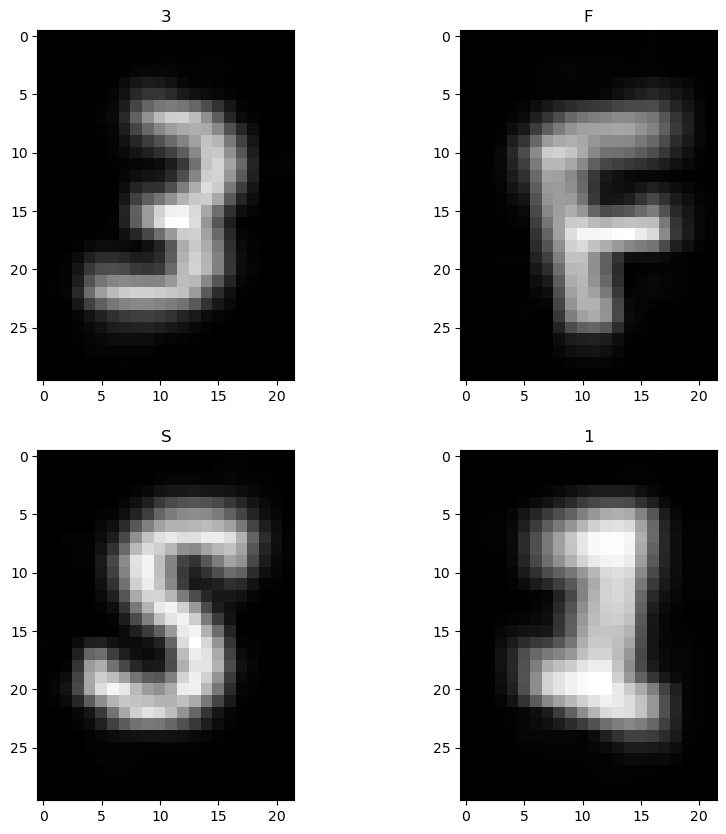

In [22]:
fig, axs = plt.subplots(2,2 , figsize=(10, 10))
for i in range(4):
    N = X.shape[0]
    n = np.random.randint(N)
    axs[i//2, i%2].imshow(X[n], cmap='gray')
    axs[i//2, i%2].set_title(itoc[np.argmax(Y[n])])


## 3.2: Data split

In [23]:
train_split = 0.9
N = X.shape[0]
n = int (N * train_split)
X_train = X[:n]
Y_train = Y[:n]
X_valid = X[n:]
Y_valid = Y[n:]

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(64832, 30, 22)
(64832, 36)
(7204, 30, 22)
(7204, 36)


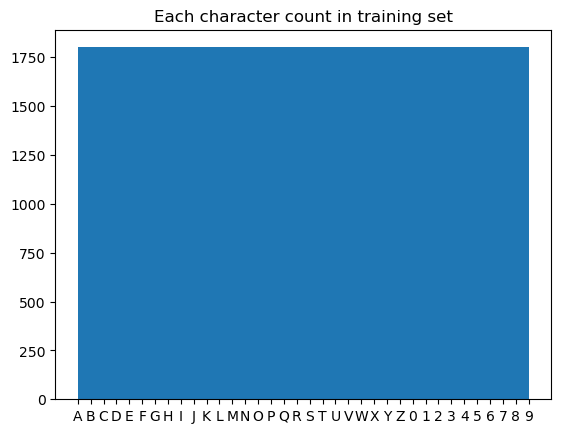

In [24]:
fig, axs = plt.subplots()
axs.hist(np.argmax(Y_train, axis=1), bins=36)
axs.set_title('Each character count in training set')
axs.set_xticks(range(36))
axs.set_xticklabels([c for c in list(ctoi.keys())])
print()

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(30, 22, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(36))
model.add(layers.Softmax())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 20, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 18, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 16, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 64)                1572928   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4

2023-04-03 16:20:58.959682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 16:20:58.959892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-03 16:20:58.959933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-03 16:20:58.959969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

In [8]:
EPOCHS = 6

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

if not LOAD_MODEL:
    history = model.fit(X_train, Y_train, epochs=EPOCHS, 
                        validation_data=(X_valid, Y_valid))
else:
    model = tf.saved_model.load(MODEL_LOAD_PATH)


Text(0.5, 1.0, 'Model Accuracy on validation and training data over 6 epochs')

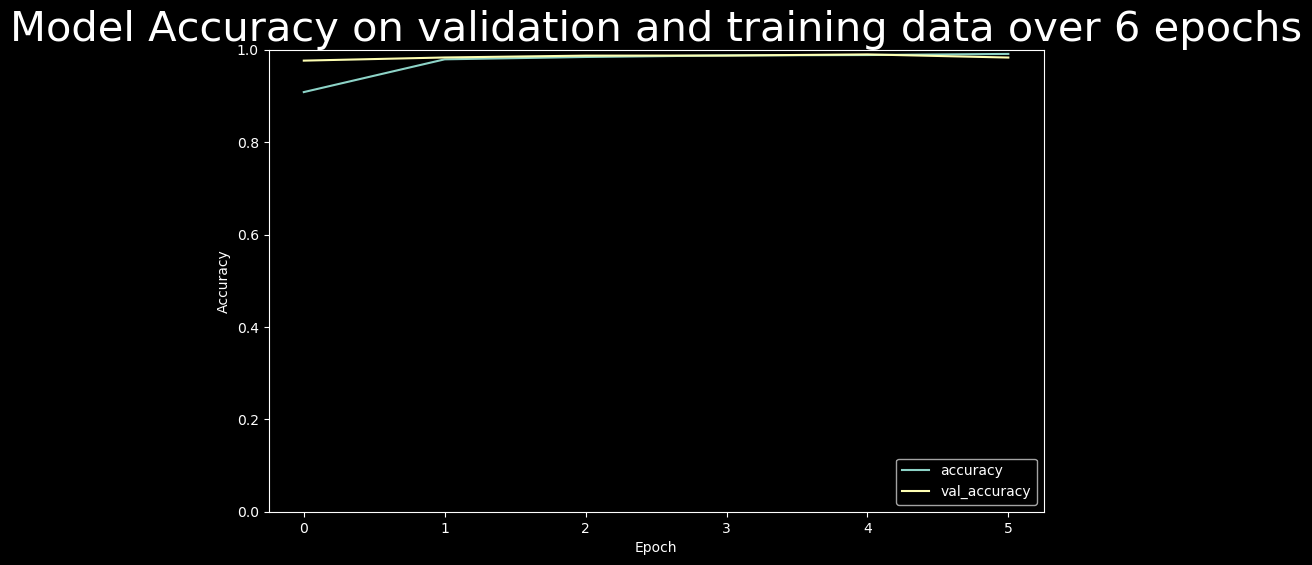

In [403]:

plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')
plt.title(f"Model Accuracy on validation and training data over {EPOCHS} epochs", size=30)

AttributeError: '_UserObject' object has no attribute 'predict'

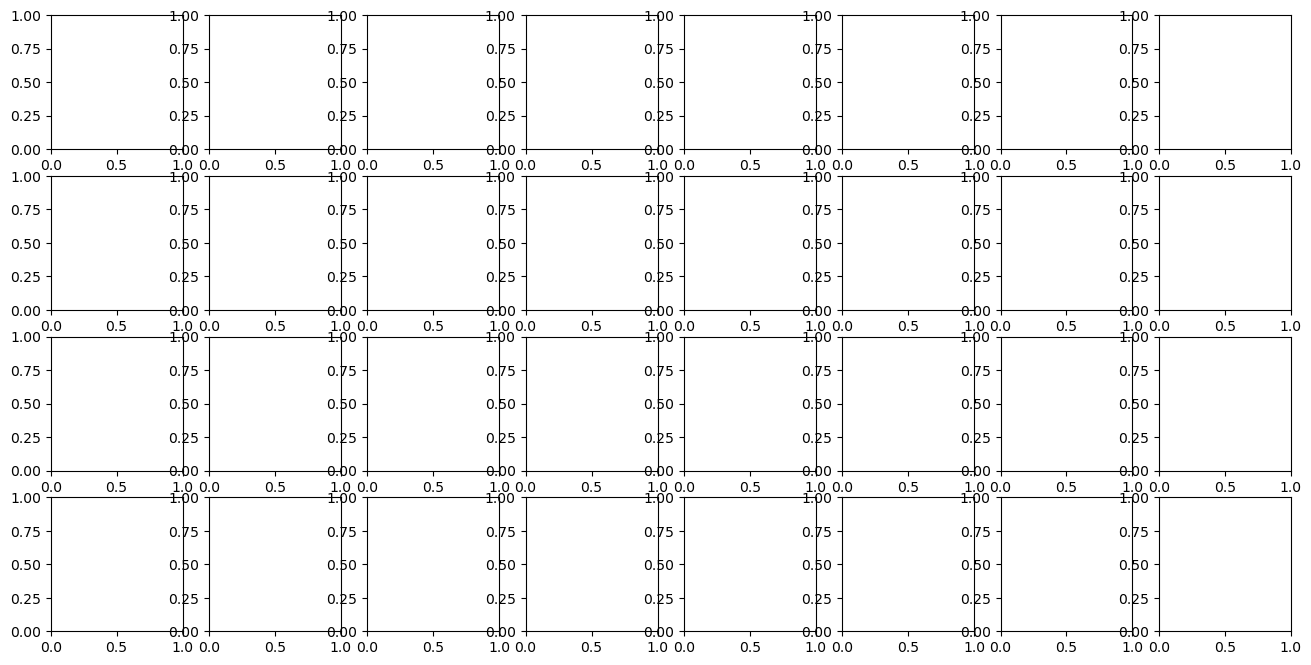

In [27]:

fig, axs = plt.subplots(4,8, figsize=(16,8))
for i in range(32):
    n = np.random.randint(X_valid.shape[0])
    input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
    label = itoc[np.argmax(Y_valid[n])]
    ypred = str(itoc[np.argmax(model.predict(input))])
    axs[i//8, i%8].imshow(X_valid[n], cmap='gray')
    if label == ypred:
        axs[i//8, i%8].set_title('Model predicts: ' + ypred, color='green')
    else:
        axs[i//8, i%8].set_title('Model predicts: ' + ypred, color='red')
fig.tight_layout()
fig.suptitle('Model predictions', fontsize=24)

In [405]:
model.save(MODEL_SAVE_PATH)

INFO:tensorflow:Assets written to: ~/ros_ws/src/controller_pkg/assets/models/character_recognition_compressed/assets


INFO:tensorflow:Assets written to: ~/ros_ws/src/controller_pkg/assets/models/character_recognition_compressed/assets


In [444]:
%%timeit -r 1 -n 1
for i in range(4):
    n = np.random.randint(X_valid.shape[0])
    input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
    label = itoc[np.argmax(Y_valid[n])]
    ypred = str(itoc[np.argmax(model(input))])
    print(ypred)

U
W
N
B
14.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
